# This notebook contains the empirical study regarding the attention mechanism.

______________
# FINAL STEPS:
* Train networks on MNIST for X epochs
* Train networks for augmented MNIST for X epochs
* Ablation Study (VAN without LKA)
* Compare Computational Costs (Deepspeed Profiler?)
 - Training time
 - Number of Modules
 - Number of parameters
 - FLOPs
 

In [1]:
# Installation and import of relevant packages
import matplotlib.pyplot as plt
import numpy as np
import pickle
import platform
import random
import time
import torch
from torchvision import datasets, transforms
from torchvision.transforms import v2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.profiler import profile, record_function, ProfilerActivity

In [3]:
# Get information about current runtime and package versions.

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Get CUDA device count
cuda_device_count = torch.cuda.device_count() if cuda_available else 0

# Get current CUDA device index
cuda_device_index = torch.cuda.current_device() if cuda_available else None

# Get name of current CUDA device
cuda_device_name = torch.cuda.get_device_name(cuda_device_index) if cuda_available else None

# Get CUDA capability of the device
cuda_capability = torch.cuda.get_device_capability(cuda_device_index) if cuda_available else None

# Get CUDA version
cuda_version = torch.version.cuda if cuda_available else None

# Get cuDNN version
cudnn_version = torch.backends.cudnn.version() if cuda_available else None

# Get PyTorch version
pytorch_version = torch.__version__

# Get OS information
os_info = platform.platform()

python_version = platform.python_version()

# Print the information
environment_dict = {"OS:", os_info,
                    "GPU:", cuda_device_name,
                    "PyTorch:", pytorch_version,
                    "CUDA:", cuda_version,
                    "cudnn:", cudnn_version,
                    "Python Version:", python_version
                   }
print("OS:", os_info)
print("GPU:", cuda_device_name)
print("PyTorch:", pytorch_version)
print("CUDA:", cuda_version)
print("cudnn:", cudnn_version)
print("Python Version:", python_version)

OS: Linux-5.15.133+-x86_64-with-glibc2.31
GPU: Tesla P100-PCIE-16GB
PyTorch: 2.1.2
CUDA: 12.1
cudnn: 8900
Python Version: 3.10.13


In [4]:
# List package versions
!pip freeze

absl-py==1.4.0
accelerate==0.27.2
access==1.1.9
affine==2.4.0
aiobotocore==2.11.2
aiofiles==22.1.0
aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1701099469104/work
aiohttp-cors==0.7.0
aioitertools==0.11.0
aiorwlock==1.3.0
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1667935791922/work
aiosqlite==0.19.0
albumentations==1.4.0
alembic==1.13.1
altair==5.2.0
annotated-types @ file:///home/conda/feedstock_root/build_artifacts/annotated-types_1696634205638/work
annoy==1.17.3
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1702909220329/work
apache-beam==2.46.0
aplus==0.11.0
appdirs==1.4.4
archspec @ file:///home/conda/feedstock_root/build_artifacts/archspec_1699370045702/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1692818318753/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1695386546427/work
array-record==0.5.0
arrow @ file:///home/conda/fe

In [ ]:
######################################
### CREATE CLUTTERED MNIST DATASET ###
######################################

In [5]:
# Create Transformation classes

class RandomPlacement(object):
  def __call__(self, img):
    canvas = torch.zeros(1,100,100)
    x = torch.randint(0, 73, (1,))
    y = torch.randint(0, 73, (1,))
    canvas[:, x:x+28, y:y+28] = img

    return canvas

class RandomCropAndCombine(object):
  def __init__(self, dataset):
    self.dataset = dataset

  def __call__(self, canvas):
    for _ in range(8):
      img, _ = random.choice(self.dataset)
      img = transforms.ToTensor()(img)
      x = torch.randint(0, 91, (1,))
      y = torch.randint(0, 91, (1,))
      patch = transforms.RandomCrop((9,9))(img)
      canvas[:, x:x+9, y:y+9] += patch
      canvas = canvas.clamp(0, 1)

    return canvas

In [6]:
# Create cluttered MNIST dataset, split datasets and create DataLoaders.

# Set seed for reproducability
torch.manual_seed(1)
np.random.seed(1)
generator = torch.Generator().manual_seed(1)

# Set batch size parameter
BATCH_SIZE = 128

# Define data transformations
original_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_original = datasets.MNIST(root='/content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/', train=True, download=True, transform=None)
augmented_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    #transforms.RandomRotation(30),
    RandomPlacement(),
    RandomCropAndCombine(mnist_original),
])

# Train datasets
mnist_dataset_train = datasets.MNIST(root='/content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/', train=True, download=True, transform=original_transform)
augmented_dataset_train = datasets.MNIST(root='/content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/', train=True, download=True, transform=augmented_transform)

# Test datasets
augmented_dataset_test = datasets.MNIST(root='/content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/', train=False, download=True, transform=augmented_transform)
mnist_dataset_test = datasets.MNIST(root='/content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/', train=False, download=True, transform=original_transform)

# Split train dataset into 90% train and 10% validation data
mnist_train, mnist_val = torch.utils.data.random_split(dataset=mnist_dataset_train, lengths=[0.9, 0.1], generator=generator)
augmented_train, augmented_val = torch.utils.data.random_split(dataset=augmented_dataset_train, lengths=[0.9, 0.1], generator=generator)

# Create data loaders for original and augmented datasets

# Load train data
mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=BATCH_SIZE, shuffle=True)
train_loader = torch.utils.data.DataLoader(dataset=augmented_train, batch_size=BATCH_SIZE, shuffle=True)
# Load validation data
mnist_val_loader = torch.utils.data.DataLoader(dataset=mnist_val, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=augmented_val, batch_size=BATCH_SIZE, shuffle=True)
# Load test data
test_loader = torch.utils.data.DataLoader(dataset=augmented_dataset_test, batch_size=BATCH_SIZE, shuffle=False)
mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_dataset_test, batch_size=BATCH_SIZE, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 45905266.45it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1530998.89it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 12046093.92it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4122598.74it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab Notebooks/Masterarbeit - Coding/data/MNIST/raw



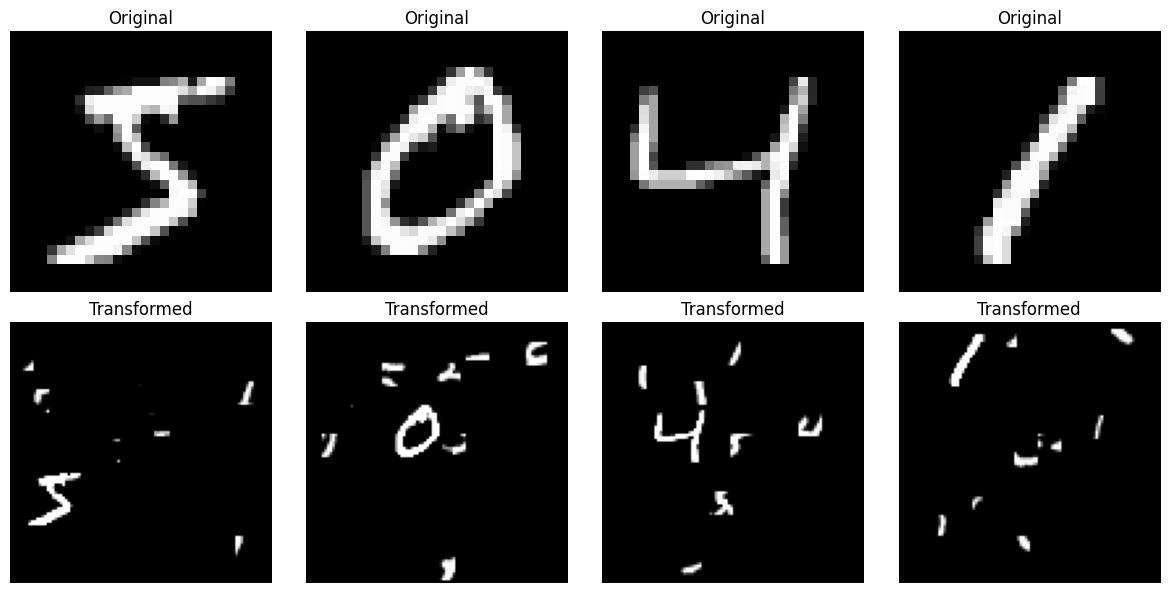

In [8]:
# Plot the original and the augmented dataset
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
  original_img, _ = mnist_original[i]
  original_img = transforms.ToTensor()(original_img).squeeze(0)
  axes[0, i].imshow(original_img, cmap='gray')
  axes[0, i].axis('off')
  axes[0, i].set_title('Original')

  augmented_img, _ = augmented_dataset_train[i]
  augmented_img = augmented_img.squeeze(0)
  axes[1, i].imshow(augmented_img, cmap='gray')
  axes[1, i].axis('off')
  axes[1, i].set_title('Transformed')
    
plt.tight_layout()
plt.show()

In [ ]:
###############################################################
### Helper Trainer Class to faciliate training the networks ###
###############################################################

In [9]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, test_loader,
                 num_epochs, estimate_step=100, save_checkpoints=True, path='model'):
        
        self.model = model
        self.optimizer = optimizer
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
        self.criterion = nn.CrossEntropyLoss()
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.num_epochs = num_epochs
        self.estimate_step = estimate_step
        self.model_name = type(self.model).__name__
        self.path = path
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.save_checkpoints = save_checkpoints
        self.running_loss_train = []
        self.running_loss_val = []
        self.train_time_per_epoch = []
        self.total_epochs_trained = 0
        self.test_accuracy = None
        self.inference_time = None

    
    def train(self):
        '''
        Function to train the model. Trains the model on a training dataset and evaluates the current performance
        on a validation dataset at the end of each epoch. Reduces the learning rate, if there is no
        improvement in the validation loss for 10 epochs. 
        '''
        self.model.to(self.device)
        self.model.train()
        for epoch in range(self.num_epochs):
            # Start timer
            #torch.cuda.synchronize() if self.device == 'cuda' else None
            start_epoch = time.time()
            
            # Training process for one epoch
            self.model.train(True)
            running_loss_train = 0.00
            for batch_idx, (data, target) in enumerate(self.train_loader):
                data, target = data.to(self.device), target.to(self.device)
                self.optimizer.zero_grad(set_to_none=True)
                output = self.model(data)
                loss = self.criterion(output, target)
                running_loss_train += loss.item()
                loss.backward()
                self.optimizer.step()
                if batch_idx % self.estimate_step == 0:
                    print(f'Epoch {epoch+1}/{self.num_epochs}, Batch {batch_idx}/{len(self.train_loader)}, Train Loss: {loss.item():.4f}')     
            avg_loss_train = running_loss_train / len(self.train_loader)
            self.running_loss_train.append(avg_loss_train)
            
            # Validate model at the end of each epoch
            self.model.eval()
            running_loss_val = 0.00
            with torch.no_grad():
                for i, (data_val, target_val) in enumerate(self.val_loader):
                    data_val, target_val = data_val.to(self.device), target_val.to(self.device)
                    output_val = self.model(data_val)
                    loss_val = self.criterion(output_val, target_val)
                    running_loss_val += loss_val.item()
                avg_loss_val = running_loss_val / len(self.val_loader)
                self.running_loss_val.append(avg_loss_val)
            
            # Recuce LR if model does not improve for 10 epochs
            self.scheduler.step(avg_loss_val)
            
            # Track training time for each epoch
            #torch.cuda.synchronize() if self.device == 'cuda' else None
            end_epoch = time.time()
            self.train_time_per_epoch.append(end_epoch-start_epoch)
            print(f'Model {self.model_name} at epoch {epoch+1}/{self.num_epochs}: Avg Train Loss: {avg_loss_train:.4f}, Avg Val Loss: {avg_loss_val:.4f}')
            
            # Increase epoch counter
            self.total_epochs_trained += 1
            
            # Save checkpoint at the end of each epoch
            if self.save_checkpoints:
                self.save_checkpoint(self.path)
            
        # Print total training time at the end
        train_time = "{:.2f} minutes".format(sum(self.train_time_per_epoch) / 60)
        print(f'Model {self.model_name} took {train_time} to run on {self.total_epochs_trained} epochs.')
        
                
    def eval(self):
        '''
        Function to evaluate the performance of the model.
        Therefore, the models accuracy on a test dataset is measured.
        '''
        self.model.to(self.device)
        self.model.eval()
        correct = 0
        total = 0
        
        #torch.cuda.synchronize() if self.device == 'cuda' else None
        start_eval = time.time()
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        self.test_accuracy = correct / total
        
        #torch.cuda.synchronize() if self.device == 'cuda' else None
        end_eval = time.time()
        self.inference_time = end_eval - start_eval
        print(f'Test Accuracy for {self.model_name}: {self.test_accuracy:.4f} - in {self.inference_time} seconds.')
        
    def save_checkpoint(self, path):
        '''
        Function to save the current state of the model, optimizer and scheduler.
        Also saves the model metrics training loss, validation loss, accuracy,
        training and inference time.
        '''
        torch.save({'epoch': self.total_epochs_trained,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'scheduler_state_dict': self.scheduler.state_dict(),
                    'loss': self.running_loss_train[-1],
                    'running_loss_train': self.running_loss_train,
                    'running_loss_val': self.running_loss_val,
                    'test_accuracy': self.test_accuracy,
                    'train_time': self.train_time_per_epoch,
                    'inference_time': self.inference_time}, 
                    f'{path}.pth')

In [ ]:
###############################################
### CNN model for MNIST and cluttered MNIST ###
###############################################
# NOTE: Only difference if the models is the linear layer fc1. Input features needs adjustment as the size of the input images is different.

In [10]:
###############################
####### CNN Model MNIST #######
###############################
class CNN_MNIST(nn.Module):
    def __init__(self, num_classes=10, image_channels=1):
        super(CNN_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(image_channels, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(9216, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

In [11]:
#################################
####### CNN Model Clutter #######
#################################
class CNN(nn.Module):
    def __init__(self, num_classes=10, image_channels=1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(image_channels, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(147456, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

In [ ]:
###############################################
### VAN model for MNIST and cluttered MNIST ###
###############################################

In [12]:
###############################
####### VAN Model MNIST #######
###############################
class Downsampling_MNIST(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride):
    super().__init__()

    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=1, bias=False)

  def forward(self, x):

    x = self.conv(x)

    return x


class Block_MNIST(nn.Module):
  def __init__(self, channels, expansion_ratio, dropout):
    super().__init__()

    self.batch_norm1 = nn.BatchNorm2d(channels) # Set running statistics off in testing? -> Check if done using model.eval()
    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels ,kernel_size=1)
    self.act1 = nn.GELU()
    self.LKA = LKA_MNIST(in_channels=channels, out_channels=channels)
    self.batch_norm2 = nn.BatchNorm2d(channels)
    self.FFN = FFN_MNIST(channels=channels, expansion_ratio=expansion_ratio, dropout=dropout)

  def forward(self, x):
    x = self.batch_norm1(x)
    x = self.conv1(x)
    x = self.act1(x)
    x = self.LKA(x)
    x = self.batch_norm2(x)
    x = self.FFN(x)

    return x


class FFN_MNIST(nn.Module):
  def __init__(self, channels, expansion_ratio, dropout):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels*expansion_ratio, kernel_size=1)
    self.conv2 = nn.Conv2d(in_channels=channels*expansion_ratio, out_channels=channels*expansion_ratio,
                           kernel_size=3, stride=1, padding=1, groups=channels*expansion_ratio)  #DW3x3Conv
    self.act1 = nn.GELU()
    self.conv3 = nn.Conv2d(in_channels=channels*expansion_ratio, out_channels=channels, kernel_size=1)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.act1(x)
    x = self.conv3(x)
    x = self.dropout(x)

    return x


class LKA_MNIST(nn.Module):
  def __init__(self, in_channels, out_channels, k=1):
    super().__init__()
    '''
    When groups == in_channels and out_channels == K * in_channels,
    where K is a positive integer, this operation is also known as a “depthwise convolution”.
    '''
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels*k, kernel_size=5, groups=in_channels)#DW-Conv
    self.conv2 = nn.Conv2d(in_channels=in_channels*k, out_channels=in_channels*k, kernel_size=5,
                           dilation=3, groups=in_channels, padding=8)#DW-D-Conv
    self.conv3 = nn.Conv2d(in_channels=in_channels*k, out_channels=out_channels, kernel_size=1) #1x1 Conv

  def forward(self, x):
    input = x.clone()
    attn = self.conv1(x)
    attn = self.conv2(attn)
    attn = self.conv3(attn)

    return input * attn


class VAN_MNIST(nn.Module):
  def __init__(self, num_classes=10, stages=4, l=[2, 2, 1, 1], channels=[32, 64, 128, 256],
               expansion_ratio=[2, 2, 2, 2], image_channels=1, dropout=0.5):
    super().__init__()
    '''
    The block and downsampler need to be initialized within the __init__ method in order to
    determine the number of parameters correctly. This also makes the moving to device easier,
    as moving the whole model will move the blocks and downsamplers aswell.
    '''
    self.stages = stages
    self.channels = channels
    self.expansion_ratio = expansion_ratio
    self.l = l
    self.num_classes = num_classes
    self.classifier = nn.Linear(in_features=channels[-1], out_features=num_classes)

    for j in range(self.stages):
      downsampler = Downsampling_MNIST(in_channels=image_channels if j == 0 else self.channels[j-1],
                                 out_channels=self.channels[j],
                                 kernel_size=3, stride=2)
      block = nn.ModuleList([Block_MNIST(channels=self.channels[j],
                                   expansion_ratio=self.expansion_ratio[j],
                                   dropout=dropout)
                                   for _ in range(self.l[j])])

      setattr(self, f'downsampler_{j+1}', downsampler)
      setattr(self, f'block_{j+1}', block)

  def forward(self, x):

    for j in range(self.stages):

      downsampler = getattr(self, f'downsampler_{j+1}')
      block = getattr(self, f'block_{j+1}')
      x = downsampler(x)
      for blk in block:
        x = blk(x)

    x = x.flatten(2).transpose(1, 2)
    x = x.mean(dim=1)
    x = self.classifier(x)

    return x

In [13]:
#################################
####### VAN Model Clutter #######
#################################
class Downsampling(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride):
    super().__init__()

    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=1, bias=False)

  def forward(self, x):

    x = self.conv(x)

    return x


class Block(nn.Module):
  def __init__(self, channels, expansion_ratio, dropout):
    super().__init__()

    self.batch_norm1 = nn.BatchNorm2d(channels) 
    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels ,kernel_size=1)
    self.act1 = nn.GELU()
    self.LKA = LKA(in_channels=channels, out_channels=channels)
    self.batch_norm2 = nn.BatchNorm2d(channels)
    self.FFN = FFN(channels=channels, expansion_ratio=expansion_ratio, dropout=dropout)

  def forward(self, x):
    x = self.batch_norm1(x)
    x = self.conv1(x)
    x = self.act1(x)
    x = self.LKA(x)
    x = self.batch_norm2(x)
    x = self.FFN(x)

    return x


class FFN(nn.Module):
  def __init__(self, channels, expansion_ratio, dropout):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels*expansion_ratio, kernel_size=1)
    self.conv2 = nn.Conv2d(in_channels=channels*expansion_ratio, out_channels=channels*expansion_ratio,
                           kernel_size=3, stride=1, padding=1, groups=channels*expansion_ratio)  #DW3x3Conv
    self.act1 = nn.GELU()
    self.conv3 = nn.Conv2d(in_channels=channels*expansion_ratio, out_channels=channels, kernel_size=1)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.act1(x)
    x = self.conv3(x)
    x = self.dropout(x)

    return x


class LKA(nn.Module):
  def __init__(self, in_channels, out_channels, k=1):
    super().__init__()
    '''
    When groups == in_channels and out_channels == K * in_channels,
    where K is a positive integer, this operation is also known as a “depthwise convolution”.
    '''
    
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels*k, kernel_size=5, groups=in_channels)#DW-Conv
    self.conv2 = nn.Conv2d(in_channels=in_channels*k, out_channels=in_channels*k, kernel_size=5,
                           dilation=3, groups=in_channels, padding=8)#DW-D-Conv
    self.conv3 = nn.Conv2d(in_channels=in_channels*k, out_channels=out_channels, kernel_size=1) #1x1 Conv

  def forward(self, x):
    input = x.clone()
    attn = self.conv1(x)
    attn = self.conv2(attn)
    attn = self.conv3(attn)

    return input * attn


class VAN(nn.Module):
  def __init__(self, num_classes=10, stages=4, l=[2, 2, 1, 1], channels=[32, 64, 128, 256],
               expansion_ratio=[2, 2, 2, 2], image_channels=1, dropout=0.5):
    super().__init__()
    '''
    The block and downsampler need to be initialized within the __init__ method in order to
    determine the number of parameters correctly. This also makes the moving to device easier,
    as moving the whole model will move the blocks and downsamplers aswell.
    '''
    self.stages = stages
    self.channels = channels
    self.expansion_ratio = expansion_ratio
    self.l = l
    self.num_classes = num_classes
    self.classifier = nn.Linear(in_features=channels[-1], out_features=num_classes)

    for j in range(self.stages):
      downsampler = Downsampling(in_channels=image_channels if j == 0 else self.channels[j-1],
                                 out_channels=self.channels[j],
                                 kernel_size=3, stride=2)
      block = nn.ModuleList([Block(channels=self.channels[j],
                                   expansion_ratio=self.expansion_ratio[j],
                                   dropout=dropout)
                                   for _ in range(self.l[j])])

      setattr(self, f'downsampler_{j+1}', downsampler)
      setattr(self, f'block_{j+1}', block)

  def forward(self, x):

    for j in range(self.stages):

      downsampler = getattr(self, f'downsampler_{j+1}')
      block = getattr(self, f'block_{j+1}')
      x = downsampler(x)
      for blk in block:
        x = blk(x)

    x = x.flatten(2).transpose(1, 2)
    x = x.mean(dim=1)
    x = self.classifier(x)

    return x

In [ ]:
################################
### TRAINING OF THE NETWORKS ###
################################

In [ ]:
####################
### CNN Training ###
####################

In [ ]:
# Initialize CNN on MNIST
cnn_mnist = CNN_MNIST()
cnn_mnist_optimizer = optim.AdamW(cnn_mnist.parameters(), lr=1e-3)
cnn_mnist_trainer = Trainer(model=cnn_mnist, optimizer=cnn_mnist_optimizer,
                            train_loader=mnist_train_loader, val_loader=mnist_val_loader, test_loader=mnist_test_loader,
                            num_epochs=25, save_checkpoints=True, path=f'CNN_MNIST()')

In [ ]:
# Train CNN on MNIST
cnn_mnist_trainer.train()

In [ ]:
# Evaluate CNN on MNIST
cnn_mnist_trainer.eval()

In [ ]:
# Initialize CNN on cluterred MNIST
cnn_clutter = CNN()
cnn_clutter_optimizer = optim.AdamW(cnn_clutter.parameters(), lr=1e-3)
cnn_clutter_trainer = Trainer(model=cnn_clutter, optimizer=cnn_clutter_optimizer,
                            train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
                            num_epochs=50, save_checkpoints=True, path=f'CNN_CLUTTER()')


In [ ]:
# Train CNN on cluttered MNIST
cnn_clutter_trainer.train()

In [ ]:
# Evaluate CNN on cluterred MNIST
cnn_clutter_trainer.eval()

In [ ]:
####################
### VAN Training ###
####################

In [14]:
# Initialize VAN on MNIST
van_mnist = VAN_MNIST(channels=[64, 128], stages=2, l=[1, 1], expansion_ratio=[2, 4])
van_mnist_optimizer = optim.AdamW(van_mnist.parameters(), lr=1e-3)
van_mnist_trainer = Trainer(model=van_mnist, optimizer=van_mnist_optimizer,
                            train_loader=mnist_train_loader, val_loader=mnist_val_loader, test_loader=mnist_test_loader,
                            num_epochs=25, save_checkpoints=True, path=f'VAN_MNIST(channels=[64, 128], stages=2, l=[1, 1], expansion_ratio=[2, 4])')

In [15]:
# Train VAN on MNIST
van_mnist_trainer.train()

Epoch 1/25, Batch 0/422, Train Loss: 2.3085
Epoch 1/25, Batch 100/422, Train Loss: 0.1981
Epoch 1/25, Batch 200/422, Train Loss: 0.1124
Epoch 1/25, Batch 300/422, Train Loss: 0.0540
Epoch 1/25, Batch 400/422, Train Loss: 0.0688
Model VAN_MNIST at epoch 1/25: Avg Train Loss: 0.3032, Avg Val Loss: 0.0836
Epoch 2/25, Batch 0/422, Train Loss: 0.0560


KeyboardInterrupt: 

In [16]:
# Evaluate VAN on MNIST
van_mnist_trainer.eval()

Test Accuracy for VAN_MNIST: 0.9794 - in 2.2821242809295654 seconds.


In [21]:
# Initialize VAN on cluttered MNIST
van_clutter = VAN(channels=[64, 128], stages=2, l=[1, 1], expansion_ratio=[2, 4])
van_clutter_optimizer = optim.AdamW(van_clutter.parameters(), lr=1e-3)
van_clutter_trainer = Trainer(model=van_clutter, optimizer=van_clutter_optimizer,
                              train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
                              num_epochs=50, save_checkpoints=True, path=f'VAN_CLUTTER(channels=[64, 128], stages=2, l=[1, 1], expansion_ratio=[2, 4])')

In [22]:
# Train VAN on cluttered MNIST
van_clutter_trainer.train()

Epoch 1/50, Batch 0/422, Train Loss: 2.3171
Epoch 1/50, Batch 100/422, Train Loss: 1.3822


KeyboardInterrupt: 

In [23]:
# Evaluate VAN on cluttered MNIST
van_clutter_trainer.eval()

Test Accuracy for VAN: 0.3547 - in 37.84108352661133 seconds.


In [ ]:
###Import function for checkpoints!###

In [17]:
# TEST CMAP
! pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.2-py3-none-any.whl size=38336 sha256=8c0706e4a539fe7551cedf0356817765dc93f3635bd2b12fa9f0626c83096dc8
  Stored in directory: /root/.cache/pip/wheels/b4/68/bb/d10381e86dc0de1c9354bce3d86bffcd247305058c40ce2e55
Successfully built grad-cam


In [58]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image

# Load the pre-trained model

def get_gradcam(model, img_tensor, target_layer):
    def hook_function(module, grad_in, grad_out):
        global gradients
        gradients = grad_out[0]
    
    target_layer.register_forward_hook(hook_function)
    
    output = model(img_tensor)
    pred_class = output.argmax(dim=1).item()
    
    model.zero_grad()
    class_loss = output[0, pred_class]
    class_loss.backward()
    
    grads = gradients
    activations = target_layer.output[0]
    
    weights = torch.mean(grads, dim=(2, 3), keepdim=True)
    cam = torch.sum(weights * activations, dim=1).squeeze().detach().numpy()
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (img_tensor.shape[2], img_tensor.shape[3]))
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    
    return cam

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def get_gradcam(model, image, target_layer):
    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Register hooks
    hook_handles = []
    hook_handles.append(target_layer.register_forward_hook(forward_hook))
    hook_handles.append(target_layer.register_backward_hook(backward_hook))

    # Add batch dimension and prepare the input
    image = img_tensor.unsqueeze(0).unsqueeze(0)  # shape: [1, 1, 28, 28]

    # Forward pass
    model.eval()
    output = model(image)
    pred_class = output.argmax(dim=1).item()

    # Backward pass
    model.zero_grad()
    output[0, pred_class].backward()

    # Remove hooks
    for handle in hook_handles:
        handle.remove()

    # Get gradients and activations
    gradients = gradients[0].cpu().data.numpy()[0]
    activations = activations[0].cpu().data.numpy()[0]

    # Compute weights
    weights = np.mean(gradients, axis=(1, 2))
    cam = np.zeros(activations.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * activations[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (image.shape[2], image.shape[3]))  # Resize to input image dimensions
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)

    return cam

# Get the Grad-CAM for the target layer (e.g., final block's FFN.conv3)

# Overlay the Grad-CAM on the original image
def overlay_cam_on_image(image, cam, alpha=0.4):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_MAGMA)
    heatmap = np.float32(heatmap) / 255
    image = image.numpy().transpose(1, 2, 0)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    overlay = heatmap + np.float32(image)
    overlay = overlay / np.max(overlay)
    return np.uint8(255 * overlay)


In [75]:
# Import model
ckpt = torch.load('/kaggle/input/van-final/pytorch/van-clutter-mnist-final/1/VAN(channels64 128 stages2 l1 1 expansion_ratio2 4)_50_epochs_Acc_9922.pth', map_location='cpu')
ckpt_model = VAN(channels=[64, 128], stages=2, l=[1, 1], expansion_ratio=[2, 4])
ckpt_model.load_state_dict(ckpt['model_state_dict'])
ckpt_optimizer = optim.AdamW(ckpt_model.parameters(), lr=1e-3)
ckpt_optimizer.load_state_dict(ckpt['optimizer_state_dict'])
ckpt_trainer = Trainer(model=ckpt_model, optimizer=ckpt_optimizer,
                       train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
                       num_epochs=30, save_checkpoints=False, path=f'Ckpt_VAN()')
ckpt_trainer.scheduler.load_state_dict(ckpt['scheduler_state_dict'])


In [97]:
model = ckpt_model.cpu()
model.eval()

augmented_img, label = augmented_dataset_train[759]
target_layer = model.cpu().block_2[-1].FFN.conv3  # Adjust according to the actual block/layer you want
print(label)

6


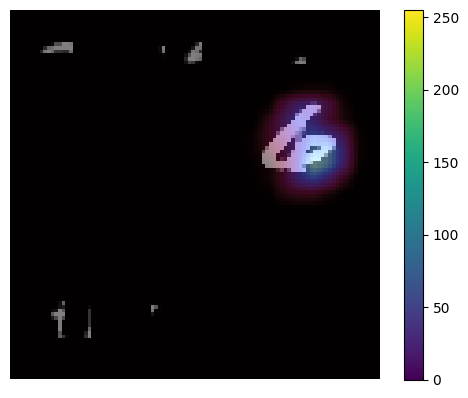

In [116]:
augmented_img = augmented_img.squeeze(0)
img_tensor = augmented_img

image = img_tensor.unsqueeze(0).to('cpu')

cam = get_gradcam(model, image, target_layer)
overlay = overlay_cam_on_image(image, cam)

# Plot the result
plt.imshow(overlay)
plt.axis('off')
plt.colorbar()
plt.show()

In [104]:
import numpy as np
import plotly.graph_objects as go
import torch
import torchvision.transforms as transforms

# Assuming `cam` is the Grad-CAM heatmap and `image` is the original image tensor
# Convert image tensor to numpy array for visualization
image_np = image.numpy().transpose(1, 2, 0)

# Normalize and resize Grad-CAM heatmap
cam_normalized = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
cam_resized = cv2.resize(cam_normalized, (image_np.shape[1], image_np.shape[0]))

# Define custom colormap (blue to red)
colors = [(0, 'rgb(0, 0, 255)'), (1, 'rgb(255, 0, 0)')]  # Blue (low) to Red (high)

# Create custom colorscale with blue for lowest values
colorscale = [
    [0.0, 'rgb(0, 255, 0)'],
    [np.min(cam_resized), 'rgb(0, 255, 0)'],
    [np.min(cam_resized) + 0.001, 'rgb(255, 255, 255)'],
    [1.0, 'rgb(128, 0, 128)']
]

# Create heatmap figure with Plotly
fig = go.Figure()

# Add original image as background
fig.add_trace(go.Image(z=image_np))

# Add heatmap overlay with custom colorscale
fig.add_trace(go.Heatmap(z=cam_resized, colorscale=colorscale, showscale=False))

# Configure layout
fig.update_layout(title='Overlay with Custom Colorscale',
                  xaxis=dict(visible=False),
                  yaxis=dict(visible=False))

# Show plot
fig.show()


**Computational Cost Comparison**

In [ ]:
def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_loss(trainer.running_loss_train, trainer.running_loss_val)

In [ ]:
!pip freeze

In [ ]:
def model_weights_equal(model1, model2):
    # Check if models have the same number of parameters
    if sum(p.numel() for p in model1.parameters()) != sum(p.numel() for p in model2.parameters()):
        return False
    
    # Check if parameters are the same
    for p1, p2 in zip(model1.parameters(), model2.parameters()):
        if not torch.all(torch.eq(p1.data, p2.data)):
            return False
    
    return True

In [ ]:
### Visual Attention Network ###

In [ ]:
#############################################################
##### Own Implementation of the Visual Attention Network ####
#############################################################
'''
Notes on the architecture from the paper:
- Simple hierarchical structure
  -> Sequence of four stages e.g
  -> Decreasig output spatial resolution:
    H/4 x W/4 -> H/8 x W/8 -> H/16 x W/16 -> H/32 x W/32 - Maybe start a 2**1??
  -> With decreasing resolution, number of channels increases.
  -> Each stage: First downsample the input with the stride number (-> Convolution)
     --- In this step, we decrease the resolution and increase the dimensions
         -> (First iteration: 100x100x1 as input and ?x?xdim[0] as output)
         -> (Second iteration: 25x25xdim[0] as input and ?x?xdim[1] as output)
  -> During each stage, the resolution (H & W) and the channels (C) remain the same and do not change
     until the next stage starts
  -> At each stage L-Groups (Blocks) of:
    - Batch Norm
    - 1x1 Conv
    - GELU Activation
    - LKA ()
    - FFN (1x1 Conv. depthwise, 3x3 Conv, GELU, 1x1 Conv.)
'''

class Downsampling(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride):
    super().__init__()

    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=1, bias=False)

  def forward(self, x):

    x = self.conv(x)

    return x


class Block(nn.Module):
  def __init__(self, channels, expansion_ratio, dropout):
    super().__init__()

    self.batch_norm1 = nn.BatchNorm2d(channels) # Set running statistics off in testing? -> Check if done using model.eval()
    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels ,kernel_size=1)
    self.act1 = nn.GELU()
    self.LKA = LKA(in_channels=channels, out_channels=channels)
    self.batch_norm2 = nn.BatchNorm2d(channels)
    self.FFN = FFN(channels=channels, expansion_ratio=expansion_ratio, dropout=dropout)

  def forward(self, x):
    x = self.batch_norm1(x)
    x = self.conv1(x)
    x = self.act1(x)
    x = self.LKA(x)
    x = self.batch_norm2(x)
    x = self.FFN(x)

    return x


class FFN(nn.Module):
  def __init__(self, channels, expansion_ratio, dropout):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels*expansion_ratio, kernel_size=1)
    self.conv2 = nn.Conv2d(in_channels=channels*expansion_ratio, out_channels=channels*expansion_ratio,
                           kernel_size=3, stride=1, padding=1, groups=channels*expansion_ratio)  #DW3x3Conv
    self.act1 = nn.GELU()
    self.conv3 = nn.Conv2d(in_channels=channels*expansion_ratio, out_channels=channels, kernel_size=1)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.act1(x)
    x = self.conv3(x)
    x = self.dropout(x)

    return x


class LKA(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=5, dilation=3, k=1):
    super().__init__()
    '''
    When groups == in_channels and out_channels == K * in_channels,
    where K is a positive integer, this operation is also known as a “depthwise convolution”.
    '''
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels*k, kernel_size=kernel_size, groups=in_channels)#DWConv
    self.conv2 = nn.Conv2d(in_channels=in_channels*k, out_channels=in_channels*k, kernel_size=kernel_size,
                           dilation=dilation, groups=in_channels, padding=8)#DWDilationConv
    self.conv3 = nn.Conv2d(in_channels=in_channels*k, out_channels=out_channels, kernel_size=1)

  def forward(self, x):
    input = x.clone()
    attn = self.conv1(x)
    attn = self.conv2(attn)
    attn = self.conv3(attn)

    return input * attn


class VAN(nn.Module):
  def __init__(self, num_classes=10, stages=4, l=[2, 2, 1, 1], channels=[32, 64, 128, 256],
               expansion_ratio=[2, 2, 2, 2], image_channels=1, dropout=0.5):
    super().__init__()
    '''
    The block and downsampler need to be initialized within the __init__ method in order to
    determine the number of parameters correctly. This also makes the moving to device easier,
    as moving the whole model will move the blocks and downsamplers aswell.
    '''
    self.stages = stages
    self.channels = channels
    self.expansion_ratio = expansion_ratio
    self.l = l
    self.num_classes = num_classes
    self.classifier = nn.Linear(in_features=channels[-1], out_features=num_classes)

    for j in range(self.stages):
      downsampler = Downsampling(in_channels=image_channels if j == 0 else self.channels[j-1],
                                 out_channels=self.channels[j],
                                 kernel_size=3, stride=2)
      block = nn.ModuleList([Block(channels=self.channels[j],
                                   expansion_ratio=self.expansion_ratio[j],
                                   dropout=dropout)
                                   for _ in range(self.l[j])])

      setattr(self, f'downsampler_{j+1}', downsampler)
      setattr(self, f'block_{j+1}', block)

  def forward(self, x):

    for j in range(self.stages):

      downsampler = getattr(self, f'downsampler_{j+1}')
      block = getattr(self, f'block_{j+1}')
      x = downsampler(x)
      for blk in block:
        x = blk(x)

    x = x.flatten(2).transpose(1, 2)
    x = x.mean(dim=1)
    x = self.classifier(x)

    return x

In [ ]:
# Initialize Baseline model
van_model = VAN(channels=[64, 128], stages=2, l=[1, 1], expansion_ratio=[2, 4])
van_optimizer = optim.AdamW(van_model.parameters(), lr=1e-3)
van_trainer = Trainer(model=van_model, optimizer=van_optimizer,
                      train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
                      num_epochs=30, save_checkpoints=True, path=f'VAN()')

In [ ]:
van_trainer.train()

In [ ]:
van_trainer.eval()

In [ ]:
ckpt = torch.load('/kaggle/input/van-final/pytorch/van-clutter-mnist-final/1/VAN(channels64 128 stages2 l1 1 expansion_ratio2 4)_50_epochs_Acc_9922.pth', map_location='cpu')

In [ ]:
ckpt.keys()

In [ ]:
ckpt['test_accuracy']

In [ ]:
ckpt['loss']

In [ ]:
### Check reproducability

In [ ]:
van_trainer.eval()

In [ ]:
VAN(channels=[64, 128], stages=2, l=[1, 1], expansion_ratio=[2, 4])
van_optimizer = optim.AdamW(van_model.parameters(), lr=1e-3)

In [ ]:
ckpt.keys()

In [ ]:
ckpt['scheduler_state_dict']

In [ ]:
### Wrap checkpoint loading into a function.

In [ ]:
ckpt_model = VAN(channels=[64, 128], stages=2, l=[1, 1], expansion_ratio=[2, 4])
ckpt_model.load_state_dict(ckpt['model_state_dict'])
ckpt_optimizer = optim.AdamW(ckpt_model.parameters(), lr=1e-3)
ckpt_optimizer.load_state_dict(ckpt['optimizer_state_dict'])
ckpt_trainer = Trainer(model=ckpt_model, optimizer=ckpt_optimizer,
                       train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
                       num_epochs=30, save_checkpoints=False, path=f'Ckpt_VAN()')
ckpt_trainer.scheduler.load_state_dict(ckpt['scheduler_state_dict'])

In [ ]:
ckpt_trainer.eval()

In [ ]:
ckpt.keys()

In [ ]:
ckpt['epoch']

In [ ]:
######################
### ABLATION STUDY ###
######################

In [ ]:
# Implementation of the VAN without an Attention Mechanism
class Downsampling_ablation(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride):
    super().__init__()

    self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=1, bias=False)

  def forward(self, x):

    x = self.conv(x)

    return x


class Block_ablation(nn.Module):
  def __init__(self, channels, expansion_ratio, dropout):
    super().__init__()

    self.batch_norm1 = nn.BatchNorm2d(channels) # Set running statistics off in testing? -> Check if done using model.eval()
    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels ,kernel_size=1)
    self.act1 = nn.GELU()
    #self.LKA = LKA(in_channels=channels, out_channels=channels)
    self.batch_norm2 = nn.BatchNorm2d(channels)
    self.abl_FFN = FFN_ablation(channels=channels, expansion_ratio=expansion_ratio, dropout=dropout)

  def forward(self, x):
    x = self.batch_norm1(x)
    x = self.conv1(x)
    x = self.act1(x)
    #x = self.LKA(x)
    x = self.batch_norm2(x)
    x = self.abl_FFN(x)

    return x


class FFN_ablation(nn.Module):
  def __init__(self, channels, expansion_ratio, dropout):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels*expansion_ratio, kernel_size=1)
    self.conv2 = nn.Conv2d(in_channels=channels*expansion_ratio, out_channels=channels*expansion_ratio,
                           kernel_size=3, stride=1, padding=1, groups=channels*expansion_ratio)  #DW3x3Conv
    self.act1 = nn.GELU()
    self.conv3 = nn.Conv2d(in_channels=channels*expansion_ratio, out_channels=channels, kernel_size=1)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.act1(x)
    x = self.conv3(x)
    x = self.dropout(x)

    return x

class VAN_ablation(nn.Module):
  def __init__(self, num_classes=10, stages=4, l=[2, 2, 1, 1], channels=[32, 64, 128, 256],
               expansion_ratio=[2, 2, 2, 2], dropout=0.5):
    super().__init__()
    '''
    The block and downsampler need to be initialized within the __init__ method in order to
    determine the number of parameters correctly. This also makes the moving to device easier,
    as moving the whole model will move the blocks and downsamplers aswell.
    '''
    self.stages = stages
    self.channels = channels
    self.expansion_ratio = expansion_ratio
    self.l = l
    self.num_classes = num_classes
    self.classifier = nn.Linear(in_features=channels[-1], out_features=num_classes)

    for j in range(self.stages):
      downsampler_ablation = Downsampling_ablation(in_channels=1 if j == 0 else self.channels[j-1],
                                 out_channels=self.channels[j],
                                 kernel_size=3, stride=2)
      block_ablation = nn.ModuleList([Block_ablation(channels=self.channels[j],
                                      expansion_ratio=self.expansion_ratio[j],
                                      dropout=dropout)
                                      for _ in range(self.l[j])])

      setattr(self, f'downsampler_{j+1}', downsampler_ablation)
      setattr(self, f'block_{j+1}', block_ablation)

  def forward(self, x):

    for j in range(self.stages):

      downsampler = getattr(self, f'downsampler_{j+1}')
      block = getattr(self, f'block_{j+1}')
      x = downsampler(x)
      for blk in block:
        x = blk(x)

    x = x.flatten(2).transpose(1, 2)
    x = x.mean(dim=1)
    x = self.classifier(x)

    return x

In [ ]:
# Initialize Baseline model
abl_model = VAN_ablation(channels=[64, 128], stages=2, l=[1, 1], expansion_ratio=[2, 4])
abl_optimizer = optim.AdamW(abl_model.parameters(), lr=1e-3)
abl_trainer = Trainer(model=vabl_model, optimizer=abl_optimizer,
                      train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
                      num_epochs=50, save_checkpoints=True, path=f'VAN_Ablation()')

In [ ]:
abl_trainer.train()

In [ ]:
abl_trainer.eval()

In [ ]:
###########################
### ACCURACY COMPARISON ###
###########################

In [ ]:
#####################################
### COMPUTATIONAL COST COMPARISON ###
#####################################

In [ ]:
'''
TODO: Check torchinfo Profiler
'''

In [ ]:
# Compare number of modueles

def count_modules(model):
    # Use model.modules() for all modules including nested ones,
    # or model.children() for immediate children only.
    num_modules = sum(1 for _ in model.modules())
    return num_modules

baseline = BaselineCNN()
van = VAN()

num_modules_cnn = count_modules(baseline)
num_modules_van = count_modules(van)

print("Number of modules in CNN:", num_modules_cnn)
print("Number of modules in VAN:", num_modules_van)

In [ ]:
# Number of parameters for the baseline CNN model
trainable_params = sum(p.numel() for p in baseline.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in baseline.parameters())
"{:,}".format(trainable_params), "{:,}".format(total_params)

In [ ]:
# Number of parameters for VAN
total_params_van = sum(p.numel() for p in van.parameters())
print(f' Total parameters of the VAN model are: {"{:,}".format(total_params_van)}')

In [ ]:
!pip install deepspeed
from deepspeed.profiling.flops_profiler import FlopsProfiler

In [ ]:
m1 = VAN(num_classes=14, stages=2, channels=[64, 128], image_channels=3, l=[1,1], expansion_ratio=[2,4])
profile_model(input_model=m1, data_loader=pc_train_loader)

In [ ]:
def profile_model(input_model, data_loader=train_loader):
    # Profile a model to get the FLOPS and Latency
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = input_model
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    prof = FlopsProfiler(model)
    # Profile at step 5 to warmup
    profile_step = 5
    for batch_idx, (data, target) in enumerate(data_loader):
      if batch_idx == profile_step:
        prof.start_profile()

      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)

      if batch_idx == profile_step:
        prof.stop_profile()
        flops = prof.get_total_flops()
        macs = prof.get_total_macs()
        params = prof.get_total_params()
        prof.print_model_profile(profile_step=profile_step)
        prof.end_profile()

      loss.backward()
      optimizer.step()

      if batch_idx == profile_step:
        break

In [ ]:
# FLOPs for VAN
for data, target in augmented_loader:
  input_data, input_target = data.to(device), target.to(device)
  break

flops_van, params = profile(van, inputs=(input_data,))
print(f'Estimated Params for VAN:, {("{:,}".format(params))}')
print(f'Estimated FLOPs for VAN:, {("{:,}".format(flops_van))}')

In [ ]:
# Detect bottlenecks for Baseline CNN

# Define your model and input data
baseline = BaselineCNN().to(device) # Your PyTorch model
input_data = input_data  # Your input data

# Perform forward pass while profiling
with profile(profile_memory=True, record_shapes=True, use_cuda=True) as prof:
    with record_function("model_inference"):
        output = baseline(input_data)

# Print profiling results
print(prof.key_averages().table(sort_by="self_cuda_time_total"))

In [ ]:
# Detect bottlenecks for VAN

# Define your model and input data
van = VAN().to(device) # Your PyTorch model
input_data = input_data  # Your input data

# Perform forward pass while profiling
with profile(profile_memory=True, record_shapes=True, use_cuda=True) as prof:
    with record_function("model_inference"):
        output = van(input_data)

# Print profiling results
print(prof.key_averages().table(sort_by="self_cuda_time_total"))

In [ ]:
# Compare convolution speed ###
from torch.autograd import profiler
input = torch.randn((128, 32, 50, 50), device="cuda")
m1 = LKA(32, 32).to("cuda")
m2 = LSKA(32, 32).to("cuda")
m3 = KA(32, 32).to("cuda")

with profiler.profile(record_shapes=True, use_cuda=True) as prof:
    with profiler.record_function("model_inference"):
        # Your PyTorch operations here
        output = m3(input)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

In [ ]:
#######################################################
### Compare difference in speed using fp32 and fp16 ###
#######################################################

In [ ]:
cuda_loader = torch.utils.data.DataLoader(dataset=augmented_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [ ]:
model = VAN(channels=[64,128], stages=2, l=[2,2], expansion_ratio=[2,4]).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
### FP32

# Creates model and optimizer in default precision
model = VAN(channels=[64,128], stages=2, l=[2,2], expansion_ratio=[2,4])
model.to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

with torch.autograd.profiler.profile(use_cuda=True) as prof:
    for epoch in range(1):
        print(f'Epoch {epoch+1} started')

        for i, (input, target) in enumerate(cuda_loader):
            #input, target = input.to('cuda'), target.to('cuda')
            optimizer.zero_grad()

            output = model(input)
            loss = criterion(output, target)

            loss.backward()

            optimizer.step()
            if i == 10:
                break
        print(f'Epoch {epoch+1} finished')
print(prof.key_averages())

In [ ]:
from torch import autocast
from torch.cuda.amp import GradScaler

### FP16

# Creates model and optimizer in default precision
model = VAN(channels=[64,128], stages=2, l=[2,2], expansion_ratio=[2,4])
model.to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

# Creates a GradScaler once at the beginning of training.
scaler = GradScaler()
with torch.autograd.profiler.profile(use_cuda=True) as prof:
    for epoch in range(1):
        print(f'Epoch {epoch+1} started')

        for i, (input, target) in enumerate(train_loader):
            input, target = input.to('cuda'), target.to('cuda')
            optimizer.zero_grad()

            # Runs the forward pass with autocasting.
            with autocast(device_type='cuda', dtype=torch.float16):
                output = model(input)
                loss = criterion(output, target)

            # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
            # Backward passes under autocast are not recommended.
            # Backward ops run in the same dtype autocast chose for corresponding forward ops.
            scaler.scale(loss).backward()

            # scaler.step() first unscales the gradients of the optimizer's assigned params.
            # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
            # otherwise, optimizer.step() is skipped.
            scaler.step(optimizer)

            # Updates the scale for next iteration.
            scaler.update()
            if i == 10 :
                break
                
        print(f'Epoch {epoch+1} finished')
print(prof.key_averages())

In [ ]:
################## ARCHIVE CODE ##########################
'''
def evaluate_significance(model_1, model_2, test_loader):
    accuracy_m1 = {}
    accuracy_m2 = {}
    # For model_1
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_1.to(device)
    model_2.to(device)
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output_1 = model_1(data)
            output_2 = model_2(data)
            _, predicted_1 = torch.max(output_1.data, 1)
            _, predicted_2 = torch.max(output_2.data, 1)
            total = target.size(0)
            correct_1 = (predicted_1 == target).sum().item()
            correct_2 = (predicted_2 == target).sum().item()
            test_accuracy_1 = correct_1 / total
            test_accuracy_2 = correct_2 / total
            accuracy_m1[i] = test_accuracy_1
            accuracy_m2[i] = test_accuracy_2
    return accuracy_m1, accuracy_m2

import numpy as np
mean_m1 = np.mean(list(acc_m1.values())).round(4)
mean_m2 = np.mean(list(acc_m2.values())).round(4)
mean_m1, mean_m2

std_m1 = np.std(list(acc_m1.values())).round(4)
std_m2 = np.std(list(acc_m2.values())).round(4)
std_m1, std_m2

import scipy
scipy.stats.ttest_rel(list(acc_m1.values()), list(acc_m2.values()))
'''

In [ ]:
'''
#############################
### Create Baseline Model ###
#############################

class BaselineCNN(nn.Module):
  def __init__(self,):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(64 * 25 * 25, 128) # TODO: Make input size dynamic

    self.relu3 = nn.ReLU()
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.relu2(x)
    x = self.pool2(x)

    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu3(x)
    x = self.fc2(x)
    return x
    '''

In [ ]:
'''
FURTHER ATTENTION BLOCKS
------------------------------------
class LSKA(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=5, dilation=3, k=1):
    super().__init__()
    
    # When groups == in_channels and out_channels == K * in_channels,
    # where K is a positive integer, this operation is also known as a “depthwise convolution”.
    self.conv1_1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels*k, kernel_size=(1, kernel_size), groups=in_channels)#DWConv
    self.conv1_2 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels*k, kernel_size=(kernel_size, 1), groups=in_channels)#DWConv
    self.conv2_1 = nn.Conv2d(in_channels=in_channels*k, out_channels=in_channels*k, kernel_size=(1, kernel_size),
                             dilation=dilation, groups=in_channels, padding=4)#DWDilationConv
    self.conv2_2 = nn.Conv2d(in_channels=in_channels*k, out_channels=in_channels*k, kernel_size=(kernel_size, 1),
                             dilation=dilation, groups=in_channels, padding=4)#DWDilationConv
    self.conv3 = nn.Conv2d(in_channels=in_channels*k, out_channels=out_channels, kernel_size=1)

  def forward(self, x):
    input = x.clone()
    attn = self.conv1_1(x)
    attn = self.conv1_2(attn)
    attn = self.conv2_1(attn)
    attn = self.conv2_2(attn)
    attn = self.conv3(attn)
    print(attn.shape)
    return input * attn
-----------------------------------
class KA(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=5, dilation=3, k=1):
    super().__init__()
    # When groups == in_channels and out_channels == K * in_channels,
    # where K is a positive integer, this operation is also known as a “depthwise convolution”.
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=13, padding='same')


  def forward(self, x):
    input = x.clone()
    attn = self.conv1(x)

    return input * attn
    
'''